## Parsing and manipulating PDB files

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

+ Two important pieces of metadata for a crystal structure are $R$ and $R_{free}$.  These measure how well the crystallographic model fits experimental data used to generate the model.  The location of these numbers are indicated in pdb files by the following text.

  ```
  REMARK   3   R VALUE     (WORKING + TEST SET)

  and 

  REMARK   3   FREE R VALUE
  ```

  Write a function called **get_R** that takes a string specifying a pdb file as an argument, extracts $R$ and $R_{free}$ from the file, and then returns them as a tuple of floats `(R,R_free)`.



In [2]:
def get_R(pdb_file):
    
    f = open(pdb_file,"r")
    lines = f.readlines()
    f.close()
    
    for l in lines:
        if l.startswith("REMARK   3   R VALUE     (WORKING + TEST SET)"):
            R = float(l[47:55])
        
        if l.startswith("REMARK   3   FREE R VALUE                    "):
            R_free = float(l[47:55])
            
    return (R,R_free)

            
get_R("1gzx.pdb")

(0.195, 0.221)

+ Create a histogram of all $C_{\alpha,i} \rightarrow C_{\alpha,i+1}$ distances in the pdb file `1stn.pdb`, where $i$ counts along residues in the sequence.  (This means the distance between $C_{\alpha}$ for residue 1 and 2, then for 2 and 3, etc.)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5., 129.]),
 array([2.96503373, 3.05462498, 3.14421623, 3.23380749, 3.32339874,
        3.41298999, 3.50258124, 3.5921725 , 3.68176375, 3.771355  ,
        3.86094626]),
 <a list of 10 Patch objects>)

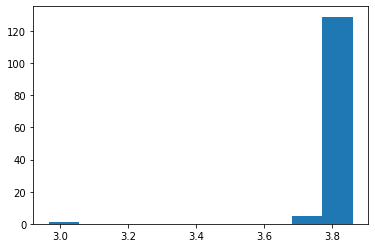

In [3]:
# Load file
f = open("1stn.pdb")
lines = f.readlines()
f.close()

# Loop through lines
out = []
for l in lines:
    
    # Grab ATOM entries
    if l[:4] == "ATOM":
        
        # Grab CA atoms
        if l[13:15] == "CA":
            
            # Grab coordinates
            x = float(l[30:38])
            y = float(l[38:46])
            z = float(l[46:54])
            
            out.append((x,y,z))

# Convert to an Nx3 numpy array 
coord = np.array(out)

# dx, dy, dz
steps = coord[1:,:] - coord[:-1,:]

# rmsd
rmsd = np.sqrt(np.sum((steps)**2,axis=1))

fig, ax = plt.subplots()
ax.hist(rmsd)


Write a function called **center_of_mass** that calculates the center of mass for a pdb file.  It should take a string specifying the pdb file as an argument and return a tuple with the center of mass in (x, y, z).  The center of mass is the average of the coordinates of the protein atoms, weighted by their mass.  The type of each atom is given on the far right of each line of the pdb.  You should use the following masses for the atoms:

|atom | mass     |
|-----|----------|
| `C` | 12.0107  |
| `N` | 14.0067  |
| `O` | 15.9994  |
| `S` | 32.065   |

In [4]:


def center_of_mass(pdb_file):
    """
    Get the center of mass from a pdb file.
    
    center of mass is for coordinate D over all atoms i is:
        sum(mass_i*D_i)/sum(mass_i) 
    
    pdb_file: string indicating the pdb file to analyze
    """
    
    # Masses of atom times
    mass_dict = {"C":12.0107,
                 "N":14.0067,
                 "O":15.9994,
                 "S":32.065}
    
    # Read lines from file
    f = open(pdb_file,'r')
    lines = f.readlines()
    f.close()
    
    # Initialize variables
    com = np.zeros(3,dtype=np.float)
    total_mass = 0.0
    
    # Go through every line
    for l in lines:
        
        # Grab ATOM entries
        if l[:4] == "ATOM":

            # Get atom type, atom mass
            atom_type = l[77]
            atom_mass = mass_dict[atom_type]

            # Extract x, y, and z and multiply by atom mass
            # Append each of these to the center of mass
            com[0] += float(l[30:38])*atom_mass
            com[1] += float(l[38:46])*atom_mass
            com[2] += float(l[46:54])*atom_mass

            total_mass += atom_mass
                        
    return com/total_mass
            
center_of_mass("1stn.pdb")

array([ 4.78272072, 22.42250936, 14.50265476])

The `HN` hydrogen atom attached to the `N` is often not in crystal structures because it is invisible in the diffraction experiment used to make the model.   Unfortunately, the `HN` atom coordinates are necessary to calculate things like structural biologists care about like [Ramachandran plots](https://en.wikipedia.org/wiki/Ramachandran_plot).  The missing atom is indicated with the red arrow in the figure below.

![hn_definition](https://raw.githubusercontent.com/harmsm/pythonic-science/master/labs/03_molecular-structure/NH_proton.png)

The function below (`calc_hn`) calculates the position of the `HN` atom for the $i^{th}$ residue given the coordinates of the $(i-1)^{th}$ `C` atom (red sphere in picture), the $i^{th}$ `N` atom (cyan sphere in picture) and the $i^{th}$ `CA` atom (cyan sphere in picture).  Write a program that takes a pdb file as input, calculates the position of each `HN` atom, and then writes out a new pdb file with the `HN` atoms written out as lines just after the `N` atoms.  This means the line encoding the position of `N` for residue 46 would be followed by a new line encoding the position of `HN` for residue 46.  You do not have to renumber the atoms in the file (but bonus points if you do).  

In [5]:

def calc_hn(CO_i_minus_one,N_i,CA_i):
    """
    Calculate the position of the HN proton. 
    
    CO_i_minus_one: array of x,y,z coordinates for *previous* 
                    "C" atom
    N_i: array of x,y,z coordinates for current "N" atom.
    CA_i: array of x,y,z coordinates for current "CA" atom.
    
    Returns: x,y,z array for HN proton.
    """
    
    # Center on N
    Ca = CA_i           - N_i
    Co = CO_i_minus_one - N_i

    # Get length of relevant vectors
    length_HN = 1.02
    length_Ca = np.sqrt(np.sum(Ca**2))
    length_Co = np.sqrt(np.sum(Co**2))

    # Dot product of H and C
    H_dot_C = length_HN*length_Co*np.cos(119.0*np.pi/180.0)

    xo = Co[0]
    yo = Co[1]
    zo = Co[2]

    xa = Ca[0]
    ya = Ca[1]
    za = Ca[2]
    
    Q = length_Ca/length_Co
    A = (xo + Q*xa)
    B = (yo + Q*ya)
    C = (zo + Q*za)

    xh = H_dot_C/(xo + yo*B/A + zo*C/A)
    yh = xh*B/A
    zh = xh*C/A

    # Translate HN back to original coordinates
    HN_i = np.array((xh,yh,zh)) + N_i
    
    return HN_i
    


In [6]:

def add_hn(pdb_file,output_pdb_file):
    """
    Calculate the positions of the HN atom in a protein pdb file
    and write them to a new pdb file.
    
    pdb_file: pdb file without HN atoms
    output_pdb_file: pdb file to write out.  Warning: if this exists,
                     it will be overwritten. 
    """
    
    # Read lines from pdb file
    f = open(pdb_file)
    lines = f.readlines()
    f.close()
    
    # Dictionary to store information for calculation
    df_dict = {"atom":[],
                "resid":[],
                "x":[],
                "y":[],
                "z":[]}
    
    # Grab relevant atoms from the lines
    for l in lines:
        if l[:4] == "ATOM":
            
            # Grab atoms of interest
            if l[13:16] in ["N  ","CA ","C  "]:
                
                # Grab atom and residue number
                atom = l[13:16].strip()
                resid = l[21:26].strip()
            
                # Record in df_dict
                df_dict["atom"].append(atom)
                df_dict["resid"].append(resid)
                df_dict["x"].append(float(l[30:38]))
                df_dict["y"].append(float(l[38:46]))
                df_dict["z"].append(float(l[46:54]))
    
    # Convert to data frame
    df = pd.DataFrame(df_dict)
    
    # Dict will hold HN positions
    HN_dict = {}
    
    # Go over all residues seen
    resids = np.unique(df.resid)
    for i in range(1,len(resids)):
        
        # Name of i and i-1 residues
        r_i = resids[i]
        r_i_minus_one = resids[i-1]

        # Grab previous CO, N and CA from the data frame
        CO_i_minus_one = np.array(df[np.logical_and(df.resid == r_i_minus_one,
                                                    df.atom == "C") ].iloc[0,2:])
        N_i =            np.array(df[np.logical_and(df.resid == r_i,
                                                    df.atom == "N") ].iloc[0,2:])
        CA_i =           np.array(df[np.logical_and(df.resid == r_i,
                                                    df.atom == "CA")].iloc[0,2:])
        
        # Calculate position of the HN atom
        HN_i = calc_hn(CO_i_minus_one,N_i,CA_i)
     
        # Record it in the dictionary
        HN_dict[r_i] = HN_i
        
    out = []
    for l in lines:
        out.append(l)
        
        # Look for "N" atom and and "HN after that"
        if l[:4] == "ATOM" and l[13:16] == "N  ":
            
            # See if we calculated HN for this residue
            resid = l[21:26].strip()
            try:
                HN_i = HN_dict[l[21:26].strip()]
            except KeyError:
                pass
                
            
            out.append("{}HN {}{:8.3f}{:8.3f}{:8.3f}{}H\n".format(l[:13],l[16:30],
                                                                  HN_i[0],HN_i[1],HN_i[2],
                                                                  l[54:77]))
    g = open(output_pdb_file,"w")
    g.write("".join(out))
    g.close()
                
    
add_hn("1stn.pdb","junk.pdb")